In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !mkdir /content/drive/MyDrive/졸플/Audio/data/spectrogram_fixed
# !cd /content/drive/MyDrive/졸플/Audio/data/spectrogram_fixed
# !unzip -qq -o /content/drive/MyDrive/졸플/Audio/data/spectrogram_fixed.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from PIL import Image, ImageFile

import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

plt.style.use('seaborn-white')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print (device)

cuda


### Dataset, Dataloader

In [5]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, label_names, transform=None):
        self.data_dir = data_dir
        self.label_names = label_names
        self.transform = transform
        self.data = []
        self.labels = []
        for i, label in enumerate(self.label_names):
            path = os.path.join(self.data_dir, label)
            for img_file in os.listdir(path):
                img_path = os.path.join(path, img_file)
                img = Image.open(img_path)
                if self.transform:
                    img = self.transform(img)
                self.data.append(img)
                self.labels.append(i)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

# Set the input shape
input_shape = (128, 128)

# Define the number of classes
num_classes = 6

# Define the path to the directory containing the spectrogram images
data_dir = '/content/drive/MyDrive/졸플/Audio/output_128/spectrogram_fixed'

# Define a list of the label names
label_names = ['regular', 'help', 'robbery', 'sexual', 'theft', 'violence']

# Define the batch size for training and validation
batch_size = 32

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the datasets
train_dataset = AudioDataset(os.path.join(data_dir), label_names, transform=transform)
val_dataset = AudioDataset(os.path.join(data_dir), label_names, transform=transform)

# Split the datasets into training and validation sets
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [6]:
print (len(train_dataset), len(val_dataset))

6436 1610


In [7]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([32, 4, 128, 128])


In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 6)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### resnet

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock

class ResNetModel(ResNet):
    def __init__(self, num_classes=6):
        super(ResNetModel, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


'''
이것은 4채널 입력을 받아들여 지정된 수의 클래스를 출력하는 torchvision.models의 ResNet18 아키텍처의 수정된 버전입니다. 
우리는 입력 크기와 일치하도록 첫 번째 컨볼루션 레이어의 입력 채널을 4로 변경하고, 
완전히 연결된 레이어를 원하는 클래스 수를 출력하는 것으로 대체한다는 것에 주목한다.
'''

'\n이것은 4채널 입력을 받아들여 지정된 수의 클래스를 출력하는 torchvision.models의 ResNet18 아키텍처의 수정된 버전입니다. \n우리는 입력 크기와 일치하도록 첫 번째 컨볼루션 레이어의 입력 채널을 4로 변경하고, \n완전히 연결된 레이어를 원하는 클래스 수를 출력하는 것으로 대체한다는 것에 주목한다.\n'

In [54]:
class DeepCNNModel(nn.Module):
    def __init__(self):
        super(DeepCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

  """
    Train a CNN model using the given train and validation data loaders.

    Args:
        model: CNN model to train.
        train_loader: Data loader for training data.
        val_loader: Data loader for validation data.
        loss_func: Loss function to use.
        optimizer: Optimizer to use for training.
        n_epochs: Number of epochs to train for.
        device: Device to use for training (e.g. 'cpu', 'cuda').
        early_stop: Number of epochs of no improvement in validation loss to stop training early. If None, do not perform early stopping.
        verbose: If True, print loss and accuracy metrics during training.

    Returns:
        trained_model: The trained model.
        best_params: The best hyperparameters found during training.
        train_losses: List of training losses per epoch.
        val_losses: List of validation losses per epoch.
        train_accuracies: List of training accuracies per epoch.
        val_accuracies: List of validation accuracies per epoch.
    """

In [9]:
def accuracy(y_pred, y_true):
  pred_labels = torch.argmax(y_pred, dim=1)
  correct = pred_labels.eq(y_true).sum().item()
  return correct / len(y_true)

In [10]:
def train_model(model, train_loader, val_loader, optimizer, loss_func, early_stop, n_epochs, progress_interval, device):

    train_losses, valid_losses, train_accs, valid_accs, lowest_loss = list(), list(), list(), list(), np.inf

    # Move the model to the GPU
    model = model.to(device)
    # Move the loss function to the GPU
    criterion = loss_func.to(device)

    for epoch in range(n_epochs):
        
        train_loss, valid_loss, train_acc, valid_acc = 0, 0, 0, 0
        
        # train the model
        model.train() # prep model for training
        for i, (x_minibatch, y_minibatch) in enumerate(train_loader):
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            y_minibatch_pred = model(x_minibatch)
            loss = criterion(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(y_minibatch_pred, y_minibatch)
            
            # print progress every 10 batches
            if (i+1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {train_loss/(i+1):.4f}, Train Acc: {train_acc/(i+1)*100:.2f}%")
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_acc / len(train_loader)
        train_accs.append(train_acc)   
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_loader:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                loss = criterion(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                valid_acc += accuracy(y_minibatch_pred, y_minibatch)
                
        valid_loss = valid_loss / len(val_loader)
        valid_losses.append(valid_loss)
        valid_acc = valid_acc / len(val_loader)
        valid_accs.append(valid_acc)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                model.load_state_dict(best_model)
                break
                
        if (epoch % progress_interval) == 0:
            print (f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}%, Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]*100:.2f}%")
            
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses, train_accs, valid_accs

In [11]:
import torch.optim as optim

model = ResNetModel()
# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Train the model
n_epochs = 30
early_stop = 20
progress_interval = 1


trained_model, lowest_loss, train_losses, valid_losses, train_accs, valid_accs = train_model(model, train_loader, val_loader, optimizer, loss_func, early_stop, n_epochs, progress_interval, device)

Epoch [1/30], Step [10/202], Train Loss: 1.6446, Train Acc: 35.94%
Epoch [1/30], Step [20/202], Train Loss: 1.4658, Train Acc: 42.34%
Epoch [1/30], Step [30/202], Train Loss: 1.4118, Train Acc: 44.27%
Epoch [1/30], Step [40/202], Train Loss: 1.3337, Train Acc: 47.89%
Epoch [1/30], Step [50/202], Train Loss: 1.2708, Train Acc: 50.69%
Epoch [1/30], Step [60/202], Train Loss: 1.2246, Train Acc: 52.97%
Epoch [1/30], Step [70/202], Train Loss: 1.2005, Train Acc: 54.29%
Epoch [1/30], Step [80/202], Train Loss: 1.1802, Train Acc: 54.77%
Epoch [1/30], Step [90/202], Train Loss: 1.1404, Train Acc: 56.46%
Epoch [1/30], Step [100/202], Train Loss: 1.1184, Train Acc: 57.28%
Epoch [1/30], Step [110/202], Train Loss: 1.1012, Train Acc: 58.41%
Epoch [1/30], Step [120/202], Train Loss: 1.0854, Train Acc: 58.98%
Epoch [1/30], Step [130/202], Train Loss: 1.0568, Train Acc: 60.05%
Epoch [1/30], Step [140/202], Train Loss: 1.0408, Train Acc: 60.74%
Epoch [1/30], Step [150/202], Train Loss: 1.0219, Train A

In [12]:
trained_model

ResNetModel(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [13]:
print(f"Training accuracy: {train_accs[-1]*100:.2f}%, Validation accuracy: {valid_accs[-1]*100:.2f}%")
print(f"Training loss: {train_losses[-1]:.4f}, Validation loss: {valid_losses[-1]:.4f}")


Training accuracy: 99.71%, Validation accuracy: 97.29%
Training loss: 0.0113, Validation loss: 0.1278


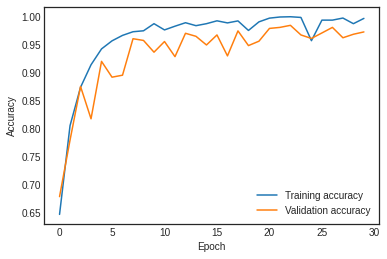

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Training accuracy')
plt.plot(valid_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

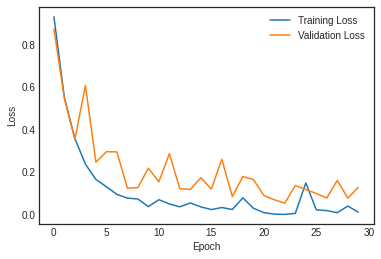

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Define the file path for the saved model
# save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_cnn.pt'
save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_resnet.pt'

# Save the trained model
# torch.save(trained_model.state_dict(), save_path)
torch.save({
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

In [31]:
# Define the path to the saved model
model_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_resnet.pt'

# Load the saved model
checkpoint = torch.load(model_path)
res_model = ResNetModel(num_classes=6)
model.load_state_dict(checkpoint['model_state_dict'])

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move the model to the device
res_model.to(device)


# Create a validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set the model to evaluation mode
res_model.eval()

# Initialize the correct and total predictions counters
correct_predictions = 0
total_predictions = 0

# Loop over the validation data loader
for inputs, labels in val_loader:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Compute the predicted outputs
    with torch.no_grad():
        outputs = res_model(inputs)

    # Get the predicted labels
    _, predicted_labels = torch.max(outputs.data, 1)

    # Update the counters
    total_predictions += labels.size(0)
    correct_predictions += (predicted_labels == labels).sum().item()

# Compute the validation accuracy
val_accuracy = 100.0 * correct_predictions / total_predictions

print(correct_predictions)
print(total_predictions)
print('Validation accuracy: %.2f %%' % val_accuracy)

245
1610
Validation accuracy: 15.22 %


### Deep CNN 

In [55]:
import torch.optim as optim

# Instantiate the model
model = DeepCNNModel()

# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 30
early_stop = 15
progress_interval = 1


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

trained_model, lowest_loss, train_losses, valid_losses, train_accs, valid_accs = train_model(model, train_loader, val_loader, optimizer, loss_func, early_stop, n_epochs, progress_interval, device)

Epoch [1/30], Step [10/202], Train Loss: 13.5713, Train Acc: 15.31%
Epoch [1/30], Step [20/202], Train Loss: 8.1316, Train Acc: 22.03%
Epoch [1/30], Step [30/202], Train Loss: 6.0403, Train Acc: 25.21%
Epoch [1/30], Step [40/202], Train Loss: 4.9532, Train Acc: 26.17%
Epoch [1/30], Step [50/202], Train Loss: 4.3659, Train Acc: 26.88%
Epoch [1/30], Step [60/202], Train Loss: 3.9204, Train Acc: 27.86%
Epoch [1/30], Step [70/202], Train Loss: 3.5998, Train Acc: 28.39%
Epoch [1/30], Step [80/202], Train Loss: 3.3603, Train Acc: 28.91%
Epoch [1/30], Step [90/202], Train Loss: 3.1528, Train Acc: 29.55%
Epoch [1/30], Step [100/202], Train Loss: 2.9864, Train Acc: 29.97%
Epoch [1/30], Step [110/202], Train Loss: 2.8554, Train Acc: 30.20%
Epoch [1/30], Step [120/202], Train Loss: 2.7419, Train Acc: 30.42%
Epoch [1/30], Step [130/202], Train Loss: 2.6422, Train Acc: 31.01%
Epoch [1/30], Step [140/202], Train Loss: 2.5573, Train Acc: 31.56%
Epoch [1/30], Step [150/202], Train Loss: 2.4884, Train 

In [56]:
trained_model

DeepCNNModel(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1,

In [57]:
print(f"Training accuracy: {train_accs[-1]*100:.2f}%, Validation accuracy: {valid_accs[-1]*100:.2f}%")
print(f"Training loss: {train_losses[-1]:.4f}, Validation loss: {valid_losses[-1]:.4f}")

Training accuracy: 93.69%, Validation accuracy: 93.19%
Training loss: 0.1732, Validation loss: 0.2338


In [58]:
# Define the file path for the saved model
# save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_cnn.pt'
save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_deep_cnn.pt'

# Save the trained model
torch.save({
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

### Test with wav

In [16]:
import librosa
import numpy as np

import torch
from torchvision.models.resnet import ResNet, BasicBlock
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image


# Define the path to the saved model
model_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_resnet.pt'

# Load the saved model
checkpoint = torch.load(model_path)
model = ResNetModel(num_classes=6)
model.load_state_dict(checkpoint['model_state_dict'])

# Define the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# Move the model to the device
model.to(device)

audio_file1 = '/content/drive/MyDrive/졸플/Audio/test/유아-성추행.wav'
audio_file2 = '/content/drive/MyDrive/졸플/Audio/test/유투브-도와주세요.wav'

In [23]:
def predict(audio_file, model):

  # Load the audio data and resample it to the desired sampling rate
  audio_data, sr = librosa.load(audio_file, sr=44100, duration=5)

  # Calculate the spectrogram of the audio data
  spec = librosa.feature.melspectrogram(audio_data, sr=sr)

  # Convert the spectrogram to decibels
  spec_db = librosa.power_to_db(spec, ref=np.max)

  # Add an additional channel to the spectrogram
  spec_db = np.repeat(spec_db[:, :, np.newaxis], 4, axis=2)
  # print("spec_db:",spec_db)
  # Resize the spectrogram to match the input shape of the model
  spec_resized = np.resize(spec_db, (1, 4, 128, 128))
  # print("spec_resized:", spec_resized)

  # Normalize the spectrogram by z-score(정규화)
  mean = np.mean(spec_resized)
  std = np.std(spec_resized)
  spec_resized = (spec_resized - mean) / std

  # print('spec shape :',spectrogram.shape)
  # print("spec :",spectrogram)

  # Convert the spectrogram to a tensor and move it to the device
  spectrogram_tensor = torch.tensor(spec_resized, dtype=torch.float).to(device)

  # Set the model to evaluation mode
  model.eval()

  # Predict the probabilities for each class
  with torch.no_grad():
      probabilities = model(spectrogram_tensor)
  print('predicted prob:', probabilities)
  # Get the index of the class with the highest probability
  predicted_class_index = torch.argmax(probabilities, dim=1)

  label_names = ['regular', 'help', 'robbery', 'sexual', 'theft', 'violence']
  label_index = predicted_class_index.item()

  print(f"Predicted class index: {label_names[int(label_index)]}")
  

  return label_names[int(label_index)]

In [24]:
import time

startTime = time.time()
# 유아-성추행
predict(audio_file1, model)

endTime = time.time() - startTime
print('걸린 시간 :',  endTime)

predicted prob: tensor([[ -8.7048,   5.4524,  -9.8120, -19.1895,   4.1433,   5.3668]])
Predicted class index: help
걸린 시간 : 0.15838623046875


In [25]:
# 유투브-도와주세요
predict(audio_file2, model)

predicted prob: tensor([[-11.9501,  -3.4895,  -8.5090, -21.4889,  -0.9494,  16.1659]])
Predicted class index: violence


'violence'